This code is the translation from Python to Pyspark for 'Optimise_task3.ipynb' file.

# First part of Spark_Optimise_Task_3

In [25]:
# I need this library for geospatial operations
# !pip install apache-sedona
# pip install --upgrade pip
# pip install scikit-learn
# pip install pyspark
# pip install apache-sedona[spark]
# pip install apache-sedona

In [26]:
# Addin Sedona extensions to PySpark session
# pip show apache-sedona
# print(spark.version)

In [60]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import geopandas as gpd
import folium
import osmnx as ox

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, when, isnan, udf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from sedona.register.geo_registrator import SedonaRegistrator
from shapely.geometry import Polygon, Point
from shapely import wkt
from shapely.wkt import loads
from pyspark.sql.types import StructType, StructField, FloatType, StringType

In [28]:
# Convert Excel to CSV
# final_dataset = pd.read_excel(r'C:\Users\Камила\BIG_DATA_PROJECT\charging_stations\task_3\task_3_dataset_enlarged.xlsx')
# final_dataset.to_csv(r'C:\Users\Камила\BIG_DATA_PROJECT\charging_stations\task_3\task_3_dataset_enlarged.csv', index=False)

Below code shows the population density for Italy in all locations (from which we get the population density for our specific locations).

+ in laptop or python it was loading too long (or even didn't open).

In [ ]:
"""from pyspark.sql import SparkSession

# Path to your CSV file
path = r'C:\Users\Камила\Downloads\ita_general_2020_csv\ita_general_2020.csv'

# Create SparkSession
spark = SparkSession.builder \
    .appName('ReadCSVExample') \
    .getOrCreate()

# Read the CSV file
df = spark.read.csv(path, inferSchema=True, header=True)

# Show the first few rows and schema
df.show(5)  # Displays the first 5 rows
df.printSchema()  # Displays the schema (column names and data types)"""


+------------------+-----------------+----------------+
|         longitude|         latitude|ita_general_2020|
+------------------+-----------------+----------------+
|  6.21569444459422|48.00013888887011|        1.061017|
| 6.216250000149777|48.00013888887011|        1.061017|
|6.2165277779275545|48.00013888887011|        1.061017|
| 6.243750000149799|48.00013888887011|        0.831058|
| 6.244027777927577|48.00013888887011|        0.831058|
+------------------+-----------------+----------------+
only showing top 5 rows

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- ita_general_2020: double (nullable = true)



checking for pyspark working example + spark session creation:

In [33]:
from pyspark.sql import SparkSession
import os

# Ensure the correct Python executable paths
os.environ["PYSPARK_PYTHON"] = r"C:\Users\Камила\AppData\Local\Programs\Python\Python311\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\Камила\AppData\Local\Programs\Python\Python311\python.exe"

# Configure Spark session
spark = SparkSession.builder \
    .appName("PythonVersionFix") \
    .master("local[*]") \
    .config("spark.executorEnv.PYSPARK_PYTHON", r"C:\Users\Камила\AppData\Local\Programs\Python\Python311\python.exe") \
    .config("spark.executorEnv.PYSPARK_DRIVER_PYTHON", r"C:\Users\Камила\AppData\Local\Programs\Python\Python311\python.exe") \
    .getOrCreate()

"""# Test
data = [(1, "a"), (2, "b"), (3, "c")]
df = spark.createDataFrame(data, ["id", "value"])
df.show()"""

'# Test\ndata = [(1, "a"), (2, "b"), (3, "c")]\ndf = spark.createDataFrame(data, ["id", "value"])\ndf.show()'

Reading data excel provided by company:

In [34]:
# Load your dataset (assume it's a CSV)
final_dataset = spark.read.csv(r"C:\Users\Камила\BIG_DATA_PROJECT\charging_stations\task_3\task_3_dataset_enlarged.csv", header=True, inferSchema=True)

## Define grids

### Part 1. Polygon

In [36]:
# Function to create a 1km grid using Shapely
def create_1km_grid_py(lat, lon):
    km_in_degree = 0.5 / 110.574
    km_lon = 0.5 / (111.320 * np.cos(np.radians(lat)))
    return str(Polygon([
        (lon - km_lon, lat - km_in_degree),
        (lon - km_lon, lat + km_in_degree),
        (lon + km_lon, lat + km_in_degree),
        (lon + km_lon, lat - km_in_degree)
    ]))

# Register the UDF
grid_udf = udf(create_1km_grid_py)

# Apply the UDF to generate the grid polygons
final_dataset = final_dataset.withColumn("geometry", grid_udf(col("gpsLat"), col("gpsLong")))

<Axes: >

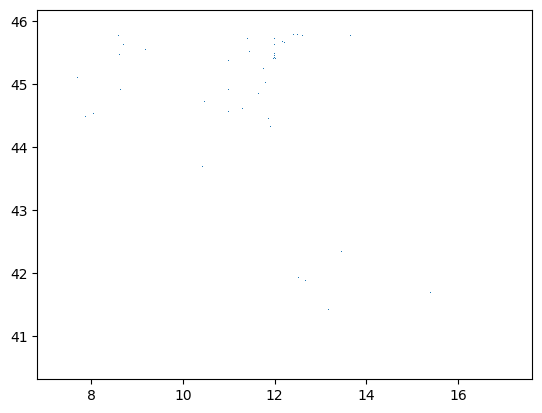

In [37]:
# Convert to GeoPandas for visualization
# Collect PySpark DataFrame to Pandas
final_dataset = final_dataset.toPandas()

# Convert the WKT column to Shapely geometries
final_dataset['geometry'] = final_dataset['geometry'].apply(wkt.loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(final_dataset, geometry='geometry', crs="EPSG:4326")

# Plot the grid
gdf.plot()

In [38]:
# Define the function to create a 1km grid
def create_1km_grid(lat, lon):
    """Creates a 0.5km x 0.5km square grid around a given point (latitude, longitude)."""
    km_lat = 0.5 / 110.574  # degrees latitude per kilometer
    km_lon = 0.5 / (111.320 * np.cos(np.radians(lat)))  # degrees longitude per kilometer

    # Define the bounds of the square grid
    lat_min = lat - (km_lat / 2)
    lat_max = lat + (km_lat / 2)
    lon_min = lon - (km_lon / 2)
    lon_max = lon + (km_lon / 2)

    # Create a polygon
    square = Polygon([
        (lon_min, lat_min),
        (lon_min, lat_max),
        (lon_max, lat_max),
        (lon_max, lat_min),
        (lon_min, lat_min)
    ])
    return square.wkt  # Return WKT (Well-Known Text) format for PySpark compatibility

In [39]:
final_dataset['polygon'] = final_dataset.apply(lambda x: create_1km_grid(x['gpsLat'], x['gpsLong']), axis=1)

In [40]:
# Convert the 'polygon' column to Shapely objects
final_dataset['polygon'] = final_dataset['polygon'].apply(wkt.loads)

In [41]:
gdf = gpd.GeoDataFrame(final_dataset, geometry='polygon', crs="EPSG:4326")

In [42]:
print(type(final_dataset))

<class 'pandas.core.frame.DataFrame'>


In [43]:
print(final_dataset)

         location     gpsLat    gpsLong  \
0      Location 1  45.099342   7.708655   
1      Location 2  45.558440   9.240295   
2      Location 3  45.568602   9.363047   
3      Location 4  45.627761   8.712500   
4      Location 5  41.924079  12.516347   
..            ...        ...        ...   
128  Location 129  44.999790   9.302020   
129  Location 130  45.703120   8.583530   
130  Location 131  44.000000  12.481811   
131  Location 132  45.769533  13.646450   
132  Location 133  45.016987  11.798013   

                                              geometry  \
0    POLYGON ((7.702291931641269 45.094820171335215...   
1    POLYGON ((9.233880046157743 45.55391802752161,...   
2    POLYGON ((9.35663083966997 45.56408017245701, ...   
3    POLYGON ((8.70607698288634 45.62323919286701, ...   
4    POLYGON ((12.51031009485218 41.91955673782281,...   
..                                                 ...   
128  POLYGON ((9.295668004057807 44.995268041335216...   
129  POLYGON ((8.57

In [55]:
gdf = gdf.drop(columns=['geometry'])

In [44]:
# Remove the 'geometry' column from the DataFrame
final_dataset = final_dataset.drop(columns=['geometry'])

# Print the DataFrame to verify
print(final_dataset)

         location     gpsLat    gpsLong  \
0      Location 1  45.099342   7.708655   
1      Location 2  45.558440   9.240295   
2      Location 3  45.568602   9.363047   
3      Location 4  45.627761   8.712500   
4      Location 5  41.924079  12.516347   
..            ...        ...        ...   
128  Location 129  44.999790   9.302020   
129  Location 130  45.703120   8.583530   
130  Location 131  44.000000  12.481811   
131  Location 132  45.769533  13.646450   
132  Location 133  45.016987  11.798013   

                                               polygon  
0    POLYGON ((7.705473462320634 45.09708110066761,...  
1    POLYGON ((9.237087469141786 45.556178956854005...  
2    POLYGON ((9.35983884288598 45.566341101789405,...  
3    POLYGON ((8.709288370108236 45.625500122199405...  
4    POLYGON ((12.51332848853559 41.9218176671552, ...  
..                                                 ...  
128  POLYGON ((9.298844002028904 44.99752897066761,...  
129  POLYGON ((8.5803142867

converting pandas dataframe again to pyspark dataframe:

In [46]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Convert Shapely geometries to WKT in the Pandas DataFrame
final_dataset['polygon'] = final_dataset['polygon'].apply(lambda geom: geom.wkt)

# Define the schema for the PySpark DataFrame
schema = StructType([
    StructField("location", StringType(), True),
    StructField("gpsLat", DoubleType(), True),
    StructField("gpsLong", DoubleType(), True),
    StructField("polygon", StringType(), True)  # WKT representation of the geometry
])

# Convert Pandas DataFrame back to PySpark DataFrame
final_dataset = spark.createDataFrame(final_dataset, schema=schema)

# Show the PySpark DataFrame
final_dataset.show(truncate=False)

+-----------+----------------+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|location   |gpsLat          |gpsLong         |polygon                                                                                                                                                                                                    |
+-----------+----------------+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Location 1 |45.09934203     |7.708654993     |POLYGON ((7.705473462320634 45.09708110066761, 7.705473462320634 45.101602959332396, 7.711836523679366 45.101602959332396, 7.711836523679366 45.09708110066761, 7.705473462320634 45.09708110066761))

In [47]:
final_dataset.printSchema()

root
 |-- location: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLong: double (nullable = true)
 |-- polygon: string (nullable = true)



In [48]:
print(type(final_dataset))

<class 'pyspark.sql.dataframe.DataFrame'>


In [49]:
print(type(gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [50]:
print(type(gdf['polygon']))

<class 'geopandas.geoseries.GeoSeries'>


In [ ]:
# I will extract this csv, so that I can continue on that later without running everything above.
# gdf.to_csv(r"C:\Users\Камила\BIG_DATA_PROJECT\charging_stations\task_3\polygon_data.csv", index=False)

In [9]:
spark.version

'3.5.2'

As in my laptop in version of 3.5 spark - sedona library can be imported, but not fully used: sedona.context or sedona.registrator, csv file is provided for later use! In the second part in 'second_part_spark_optimiser' file.